In [1]:
import logging
import time

import utils 

import awkward as ak
from coffea import processor
from coffea.nanoevents import NanoAODSchema
from coffea.analysis_tools import PackedSelection
import copy
import hist
import matplotlib.pyplot as plt
import numpy as np
import pyhf

import mplhep as hep
hep.style.use(hep.style.ATLAS)

In [2]:
N_FILES_MAX_PER_SAMPLE = 1
USE_DASK=False
USE_SERVICEX=False
USE_SAVED_FEATURES=False

In [3]:
fileset = utils.file_input.construct_fileset(
    N_FILES_MAX_PER_SAMPLE,
    use_xcache=False,
    af_name="coffea_casa",  
    input_from_eos=False,
    xcache_atlas_prefix=None,
)

print(f"processes in fileset: {list(fileset.keys())}")
print(f"\nexample of information in fileset:\n{{\n  'files': [{fileset['ttbar__nominal']['files'][0]}, ...],")
print(f"  'metadata': {fileset['ttbar__scaleup']['metadata']}\n}}")

processes in fileset: ['ttbar__nominal', 'ttbar__scaledown', 'ttbar__scaleup', 'ttbar__ME_var', 'ttbar__PS_var', 'single_top_s_chan__nominal', 'single_top_t_chan__nominal', 'single_top_tW__nominal', 'wjets__nominal']

example of information in fileset:
{
  'files': [https://xrootd-local.unl.edu:1094//store/user/AGC/nanoAOD/TT_TuneCUETP8M1_13TeV-powheg-pythia8/cmsopendata2015_ttbar_19980_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1_00000_0000.root, ...],
  'metadata': {'process': 'ttbar', 'variation': 'scaleup', 'nevts': 1278695, 'xsec': 729.84}
}


In [4]:
NanoAODSchema.warn_missing_crossrefs = False # silences warnings about branches we will not use here

executor = processor.FuturesExecutor(workers=4)

run = processor.Runner(
    executor=executor,
    schema=NanoAODSchema,
    savemetrics=True,
    metadata_cache={},
    chunksize=200000)

treename = "Events"


filemeta = run.preprocess(fileset, treename=treename)  # pre-processing



Output()

In [5]:
# labels_dict = {"ttbar": 0,
#                "single_top_s_chan":1,
#               "single_top_t_chan":2,
#               "single_top_tW":3,
#               "wjets":4}

# Keep only a subset of the background for illustration
labels_dict = {"ttbar": 0,
              "single_top_t_chan":1,
              "wjets":2}

In [6]:
# function to create column accumulator from list
def col_accumulator(a):
    return processor.column_accumulator(np.array(a))

processor_base = processor.ProcessorABC
class NSBI_analysis(processor_base):
    def __init__(self):
        super().__init__()
    
    def process(self, events):
        
        # Note: This creates new objects, distinct from those in the 'events' object
        elecs = events.Electron
        muons = events.Muon
        jets = events.Jet
        
        process = events.metadata["process"]  # "ttbar" etc.
        
        if process in ["single_top_s_chan", "single_top_tW"]: 
            return {}
        
        variation = events.metadata["variation"]  # "nominal" etc.
        
        # normalization for MC
        x_sec = events.metadata["xsec"]
        nevts_total = events.metadata["nevts"]
        lumi = 3378 # /pb

        if process != "data":
            xsec_weight = x_sec * lumi / nevts_total
        else:
            xsec_weight = 1

        electron_reqs = (elecs.pt > 10) & (np.abs(elecs.eta) < 2.4) & (elecs.pt < 500)
        muon_reqs = ((muons.pt > 10) & (np.abs(muons.eta) < 2.4)) & (muons.pt < 500)
        # jet_reqs = (jets.pt > 30) & (np.abs(jets.eta) < 2.4) & (jets.isTightLeptonVeto)
        jet_reqs = (jets.pt > 15) & (np.abs(jets.eta) < 2.4) & (ak.sum(jets.pt, axis=-1)<1750)

        # Only keep objects that pass our requirements
        elecs = elecs[electron_reqs]
        muons = muons[muon_reqs]
        jets = jets[jet_reqs]

        ######### Store boolean masks with PackedSelection ##########
        selections = PackedSelection(dtype='uint64')
        
        # Inclusive selection criteria 
        selections.add("exactly_1l", (ak.num(elecs) + ak.num(muons)) == 1)
        selections.add("atleast_4j", ak.num(jets) >= 4)
        
        selections.add("Inclusive", selections.all("exactly_1l"))
        selections.add("Inclusive", selections.all("exactly_1l", "atleast_4j"))

        selection = selections.all("Inclusive")
        selected_jets = jets[selection]
        selected_elecs = elecs[selection]
        selected_muons = muons[selection]
        selected_weights = np.ones(len(selected_jets)) * xsec_weight


        # grab lepton info
        leptons = ak.flatten(ak.concatenate((selected_elecs, selected_muons), axis=1), axis=-1)

        H_T = ak.sum(selected_jets.pt, axis=-1)
        pT_lep = leptons.pt
        eta_lep = leptons.eta
        phi_lep = leptons.phi
        
        #### calculate features ####
        features = np.zeros((len(pT_lep), 4))
        
        features[:, 0] = pT_lep
        features[:, 1] = eta_lep
        features[:, 2] = phi_lep
        features[:, 3] = H_T


        train_labels = np.full_like(pT_lep, labels_dict[process])


        output = {"train_labels": col_accumulator(train_labels.tolist()),
                  "weights": col_accumulator(selected_weights.tolist()),
                  "features": col_accumulator(features.tolist())}


        return output
        
    def postprocess(self, accumulator):
        return accumulator

In [7]:
if not USE_SAVED_FEATURES:
    
    t0 = time.monotonic()
    # processing
    output, metrics = run(
        fileset,
        treename,
        processor_instance=NSBI_analysis()
    )


    exec_time = time.monotonic() - t0


    print(f"\nexecution took {exec_time:.2f} seconds")

Output()


execution took 201.41 seconds


In [8]:
saved_data = "./cached_data/"

In [9]:
if USE_SAVED_FEATURES:
    
    features = np.load(f"{saved_data}features.npy")
    train_labels = np.load(f"{saved_data}train_labels.npy")
    weights = np.load(f"{saved_data}weights.npy")
    
else:

    # grab features and labels and convert to np array
    features = np.array(output['features'].value)
    train_labels = np.array(output['train_labels'].value, dtype='int')
    weights = np.array(output['weights'].value)

    print(weights[train_labels==0].shape)
    print(weights[train_labels==1].shape)
    print(weights[train_labels==2].shape)
    
    np.save(f"{saved_data}features.npy", features)
    np.save(f"{saved_data}train_labels.npy", train_labels)        
    np.save(f"{saved_data}weights.npy", weights)        

(2565607,)
(436311,)
(533257,)


In [10]:
features.shape

(3535175, 4)

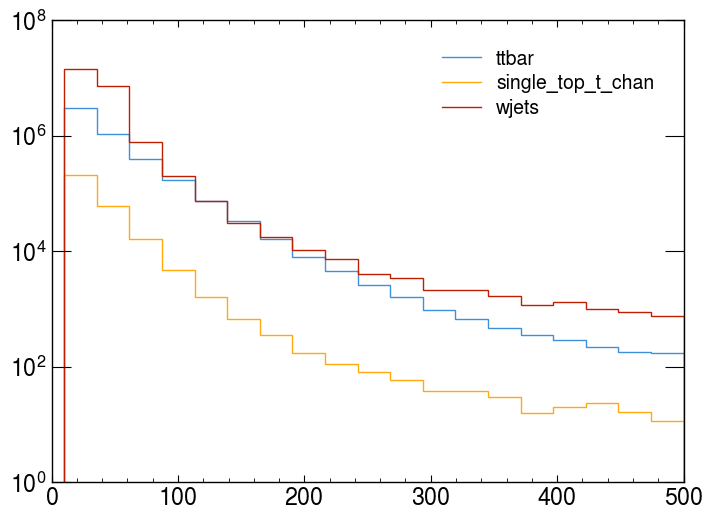

In [11]:
bins=np.linspace(10.0, 500.0, num=20)
hist_lep_pt = {}

for key in labels_dict:
    
    hist_lep_pt[key], _ = np.histogram(features[:,0][train_labels==labels_dict[key]], weights = weights[train_labels==labels_dict[key]], bins=bins)

for key in labels_dict:

    hep.histplot(hist_lep_pt[key], bins=bins, label=key)

plt.yscale('log')
plt.legend(loc='upper right')

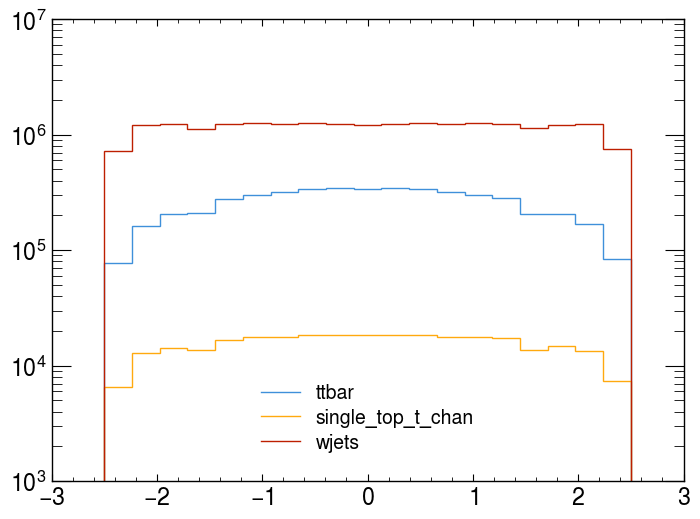

In [12]:
bins=np.linspace(-2.5, 2.5, num=20)
hist_lep_eta = {}

for key in labels_dict:
    
    hist_lep_eta[key], _ = np.histogram(features[:,1][train_labels==labels_dict[key]], weights = weights[train_labels==labels_dict[key]], bins=bins)

for key in labels_dict:

    hep.histplot(hist_lep_eta[key], bins=bins, label=key)

plt.yscale('log')
plt.legend(loc='lower center')

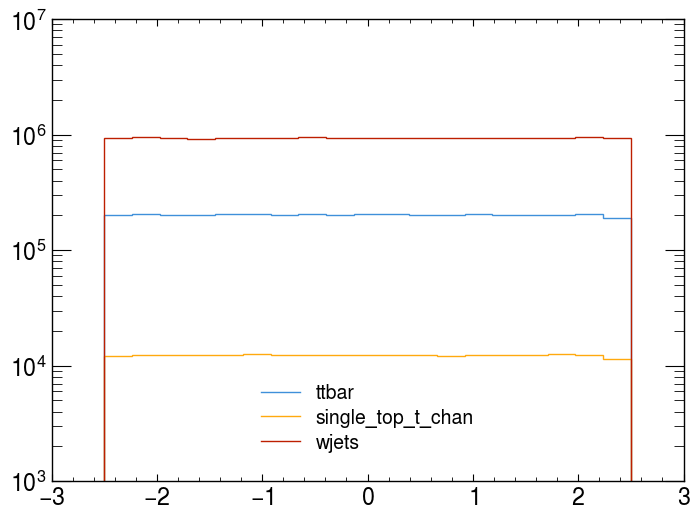

In [13]:
bins=np.linspace(-2.5, 2.5, num=20)
hist_lep_phi = {}

for key in labels_dict:
    
    hist_lep_phi[key], _ = np.histogram(features[:,2][train_labels==labels_dict[key]], weights = weights[train_labels==labels_dict[key]], bins=bins)

for key in labels_dict:

    hep.histplot(hist_lep_phi[key], bins=bins, label=key)

plt.yscale('log')
plt.legend(loc='lower center')

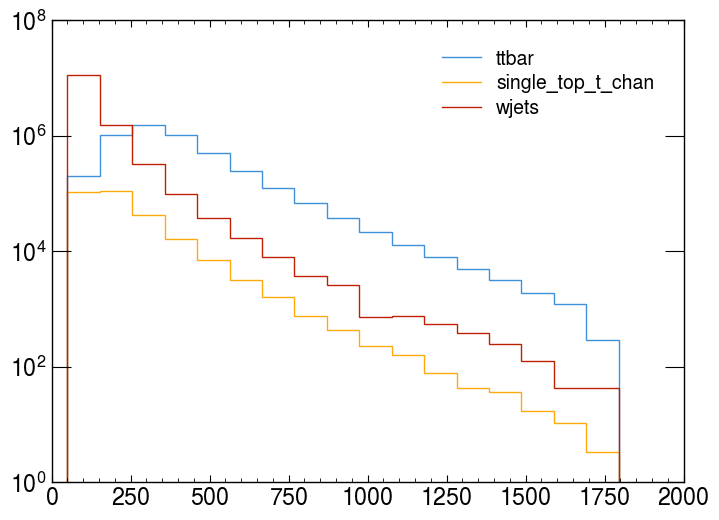

In [14]:
bins=np.linspace(50.0, 2000.0, num=20)
hist_HT = {}

for key in labels_dict:
    
    hist_HT[key], _ = np.histogram(features[:,3][train_labels==labels_dict[key]], weights = weights[train_labels==labels_dict[key]], bins=bins)

for key in labels_dict:

    hep.histplot(hist_HT[key], bins=bins, label=key)

plt.yscale('log')
plt.legend(loc='upper right')